In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import json

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
from tensorflow.keras import optimizers 

In [2]:
data_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip= True,
            zoom_range=0.2,
            shear_range=0.1,
            preprocessing_function=preprocess_input,
)

In [3]:
batch_size = 64
train_path = r"train"
train_gen = data_gen.flow_from_directory(train_path,target_size=(224,224),
                                         batch_size=batch_size,class_mode='categorical',seed=36)


val_path = r"valid"
val_gen = data_gen.flow_from_directory(val_path,target_size=(224,224),
                                         batch_size=batch_size,class_mode='categorical',seed=36)


json_file_path = r"cat_to_name.json"

with open(json_file_path, 'r') as file:
    labels = json.load(file)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [4]:
resnet = ResNet50(input_shape = (224,224,3),
                  weights = 'imagenet',
                  include_top = False
                  )
resnet.trainable = False

In [5]:
model = tf.keras.Sequential([
        resnet,
        Flatten(),
        
        Dense(256,activation='relu'),
        Dense(256,activation='relu'),
        Dense(102,activation='softmax'),
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 102)               26214     
                                                                 
Total params: 49,370,086
Trainable params: 25,782,374
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
def lr_scheduler(epoch):
    initial_lr = 0.0005
    decay_steps=5
    decay_rate=0.5
    return initial_lr * np.exp(-decay_rate * epoch / decay_steps)

In [8]:
opt = optimizers.Adam()
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
train_step = train_gen.n//batch_size
valid_step = val_gen.n//batch_size
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [10]:
r = model.fit(train_gen,
            steps_per_epoch = train_step,
            validation_data = val_gen,
            validation_steps = valid_step,
            callbacks=lr_scheduler_callback,
            epochs = 20)

Epoch 1/20
102/102 [==============================] - 79s 709ms/step - loss: 3.0642 - accuracy: 0.4115 - val_loss: 1.4310 - val_accuracy: 0.6406 - lr: 5.0000e-04
Epoch 2/20
102/102 [==============================] - 71s 696ms/step - loss: 0.8565 - accuracy: 0.7727 - val_loss: 1.0392 - val_accuracy: 0.7526 - lr: 4.5242e-04
Epoch 3/20
102/102 [==============================] - 71s 697ms/step - loss: 0.4901 - accuracy: 0.8570 - val_loss: 0.8332 - val_accuracy: 0.7852 - lr: 4.0937e-04
Epoch 4/20
102/102 [==============================] - 71s 699ms/step - loss: 0.2978 - accuracy: 0.9135 - val_loss: 0.8092 - val_accuracy: 0.8138 - lr: 3.7041e-04
Epoch 5/20
102/102 [==============================] - 72s 703ms/step - loss: 0.2378 - accuracy: 0.9269 - val_loss: 0.6667 - val_accuracy: 0.8398 - lr: 3.3516e-04
Epoch 6/20
102/102 [==============================] - 71s 692ms/step - loss: 0.1740 - accuracy: 0.9462 - val_loss: 0.6840 - val_accuracy: 0.8346 - lr: 3.0327e-04
Epoch 7/20
102/102 [========

Text(0.5, 1.0, 'Loss ')

Text(0.5, 0, 'Number of Epochs')

Text(0, 0.5, 'Loss')

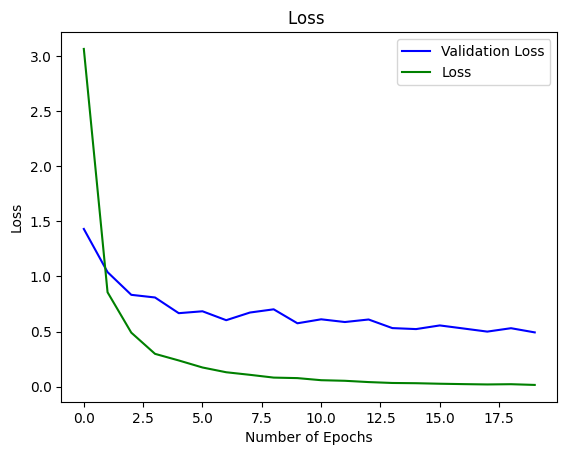

In [11]:
plt.plot(r.history['val_loss'], color='b', label="Validation Loss")
plt.plot(r.history['loss'], color='g', label="Loss")
plt.title("Loss ")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

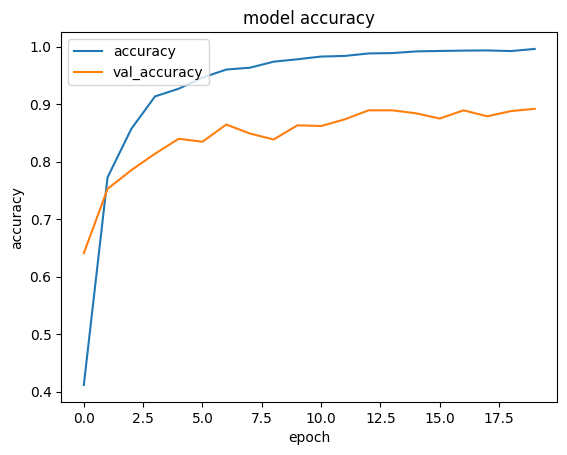

In [12]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [13]:
elist=[]
directory_path = (r"test")

files = os.listdir(directory_path)


for image in files:
    path = os.path.join(directory_path,image)
    img = Image.open(path)
    img = img.resize((224,224))
    img_array = np.array(img)
    elist.append(img_array)
    
test_images = np.array(elist)
test_images.shape
preprocessed_image = preprocess_input(test_images)

(819, 224, 224, 3)

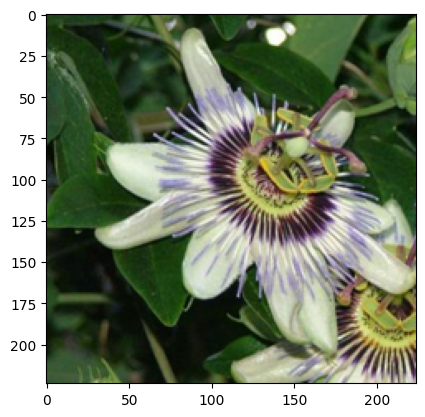

In [14]:
plt.imshow(test_images[1])

In [15]:
# this step is done because preprocess changes the images
datagen = ImageDataGenerator()
traingen = datagen.flow_from_directory(r'train',target_size = (224,224))

Found 6552 images belonging to 102 classes.


In [16]:
if train_gen.class_indices == traingen.class_indices:
    class_indices = train_gen.class_indices
    random_number = random.randint(0, preprocessed_image.shape[0])
    random_image = preprocessed_image[random_number]
    pred_matrix = model.predict(random_image.reshape(1,224,224,3))
    prediction = np.argmax(pred_matrix)
    target_class_label = list(class_indices.keys())[list(class_indices.values()).index(prediction)]
    flower_type = labels[target_class_label]

1/1 [==============================] - 1s 1s/step


(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

Text(0.5, 1.1, 'Predicted class : ball moss(93)')

Text(0.5, 1.1, 'An image from predicted class')

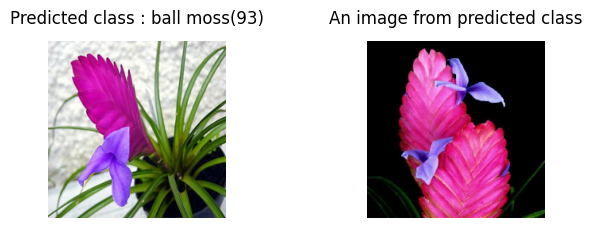

In [17]:
target_class_index = class_indices[target_class_label]
for X, y in traingen:
    if y[0][target_class_index] == 1:
        fig, axs = plt.subplots(1, 2)
        plt.subplots_adjust(wspace=0.8)

        axs[0].imshow(test_images[random_number])
        axs[0].axis('off')

        axs[1].imshow(X[0].astype('uint8'))
        axs[1].axis('off')

        axs[0].text(0.5, 1.1, f'Predicted class : {flower_type}({target_class_label})', ha='center', transform=axs[0].transAxes, fontsize=12)
        axs[1].text(0.5, 1.1, f'An image from predicted class' ,ha='center', transform=axs[1].transAxes, fontsize=12)
        plt.show()
        break